In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
pip install loguru


Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import torch.nn as nn
import nltk
from nltk.corpus import treebank
from collections import Counter
from nltk.tokenize import TreebankWordTokenizer
from loguru import logger
import time
import argparse
import matplotlib.pyplot as plt
import os
import pickle as pkl
from safetensors.torch import save_file, load_file
import json

In [4]:
# Set NLTK data path to project's data directory
nltk_data_path = os.path.join(os.getcwd(), 'data', 'nltk_data')
nltk.data.path.append(nltk_data_path)

# Download required NLTK data
if not os.path.exists(nltk_data_path):
    print(f"Downloading NLTK data to: {nltk_data_path}")
    nltk.download('treebank', download_dir=nltk_data_path)
    nltk.download('punkt', download_dir=nltk_data_path)

In [5]:
def load_and_preprocess_data():
    """
    Load and preprocess text data from Penn Treebank corpus.

    Returns:
        tuple: Contains three lists of tokenized sentences:
            - train_data: Training set (80% of data)
            - test_data: Test set (10% of data)
            - val_data: Validation set (10% of data)

    Each sentence is preprocessed by:
        1. Converting to lowercase
        2. Tokenizing using TreebankWordTokenizer
        3. Splitting into train/test/val sets
    """
    tokenizer = TreebankWordTokenizer()

    # Get sentences from Penn Treebank corpus
    sentences = treebank.sents()

    # Process each sentence
    processed = []
    for sent in sentences:
        # E sent is a list of words
        # Join the sentence into a single string and tokenize
        text = ' '.join(sent)
        tokens = tokenizer.tokenize(text.lower())
        processed.append(tokens)

    # Split into train, test, and validation sets
    train_data = processed[:int(len(processed) * 0.8)]
    test_data = processed[int(len(processed) * 0.8):int(len(processed) * 0.9)]
    val_data = processed[int(len(processed) * 0.9):]

    return train_data, test_data, val_data

In [6]:
def build_voab(data, min_freq=2):
    """
    Build vocabulary from training data with minimum frequency threshold.

    Args:
        data (list): List of tokenized sentences where each sentence is a list of tokens
        min_freq (int, optional): Minimum frequency threshold for including words. Defaults to 2.

    Returns:
        tuple: Contains two dictionaries:
            - word_to_idx: Maps words to unique integer indices
            - idx_to_word: Maps indices back to words

    The vocabulary includes special tokens:
        - <unk>: Unknown words
        - <pad>: Padding token
        - <bos>: Beginning of sentence
        - <eos>: End of sentence
    """
    counter = Counter()
    for sent in data:
        counter.update(sent)

    # Create vocabulary with special tokens
    words = ['<unk>', '<pad>', '<bos>', '<eos>']
    words.extend([word for word, freq in counter.items() if freq >= min_freq])

    word_to_idx = {word: idx for idx, word in enumerate(words)}
    idx_to_word = {idx: word for idx, word in enumerate(words)}

    return word_to_idx, idx_to_word


In [7]:
def process_data(data, word_to_idx):
    """
    Process raw text data into model-ready format by converting tokens to indices.

    Args:
        data (list): List of tokenized sentences where each sentence is a list of tokens
        word_to_idx (dict): Dictionary mapping words to unique integer indices

    Returns:
        list: List of torch tensors, where each tensor contains the indices for a sentence
            including <bos> and <eos> tokens

    Each sentence is processed by:
        1. Converting tokens to their vocabulary indices
        2. Adding beginning-of-sentence (<bos>) and end-of-sentence (<eos>) tokens
        3. Converting to a PyTorch tensor
    """
    processed = []
    for sent in data:
        # convert tokens to indices
        indices = [word_to_idx.get(token, word_to_idx['<unk>']) for token in sent]
        # Add <bos> and <eos> tokens
        indices = [word_to_idx['<bos>']] + indices + [word_to_idx['<eos>']]
        processed.append(torch.tensor(indices))

    return processed

In [8]:
def create_batches(data, word_to_idx, batch_size=32):
    """
    Create batches from processed data for model training.

    Args:
        data (list): List of torch tensors containing processed sentences
        word_to_idx (dict): Dictionary mapping words to unique integer indices
        batch_size (int, optional): Size of each batch. Defaults to 32.

    Returns:
        list: List of torch tensors, where each tensor is a batch of padded sequences
            with shape (batch_size, max_sequence_length)

    The function:
        1. Sorts sequences by length in descending order for efficient padding
        2. Groups sequences into batches of specified size
        3. Pads shorter sequences in each batch to match the longest sequence
        4. Converts batches to torch tensors
    """
    data.sort(key=lambda x: len(x), reverse=True)
    total_len = len(data)
    num_batches = (total_len + batch_size - 1) // batch_size

    batches = []
    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        max_len = len(batch[0])
        padded = [torch.cat([seq, torch.tensor([word_to_idx['<pad>']] * (max_len - len(seq)))]) if len(seq) < max_len else seq for seq in batch]
        batches.append(torch.stack(padded))
    return batches

In [9]:
class Network(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, cell='lstm', dropout=0.5):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, 
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, x, hidden=None):
        # Ensure input tensor is on correct device
        x = x.to(next(self.parameters()).device)
        
        embeds = self.embed(x)  # (batch, seq_len, embed_size)
        lstm_out, hidden = self.lstm(embeds, hidden)
        logits = self.fc(lstm_out)  # (batch, seq_len, vocab_size)
        return logits, hidden

In [10]:
def train(model, train_batches, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    
    for batch in train_batches:
        optimizer.zero_grad()
        
        # Move batch to device
        batch = batch.to(device)
        
        # Inputs and targets
        inputs = batch[:, :-1]  # (batch, seq_len-1)
        targets = batch[:, 1:]   # (batch, seq_len-1)
        
        # Forward pass
        outputs, _ = model(inputs)  # (batch, seq_len-1, vocab_size)
        
        # Reshape for loss calculation
        loss = criterion(outputs.reshape(-1, outputs.size(-1)), 
                       targets.reshape(-1))
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_batches)

In [11]:
def evaluate(model, eval_batches, criterion, device):
    """
    Evaluate the model on validation/test data.

    Args:
        model (nn.Module): The neural network model
        eval_batches (torch.Tensor): Evaluation data batches
        criterion: Loss function

    Returns:
        float: Average loss over all batches in the evaluation set
    """
    model.eval()
    total_loss = 0.0

    # point: why no_grad() is needed when we have model.eval()
    with torch.no_grad():
        for batch in eval_batches:
            inputs = batch[:, :-1].to(device)
            targets = batch[:, 1:].to(device)

            outputs, _ = model(inputs)
            loss = criterion(outputs.reshape(-1, outputs.size(-1)),
                             targets.reshape(-1))
            total_loss += loss.item()


    return total_loss / len(eval_batches)

def calculate_perplexity(loss):
    return torch.exp(torch.tensor(loss))

In [12]:
# function to load vocabulary mappings
def load_vocab(vocab_path):
    with open(vocab_path, 'r') as f:
        vocab_dict = json.load(f)
    return vocab_dict['word_to_idx'], vocab_dict['idx_to_word']

# function to load tensors from safetensors file
def load_tensors(file_path):
    loaded_tensors = load_file(file_path)
    return loaded_tensors['train'], loaded_tensors['valid'], loaded_tensors['test']


In [13]:
def generate_text(model, word_to_idx, idx_to_word, device, seed_text='the', max_length=20):
    """Generate text using the trained language model.

    Args:
        model: The trained language model
        word_to_idx (dict): Dictionary mapping words to indices
        idx_to_word (dict): Dictionary mapping indices to words
        seed_text (str, optional): Initial text to condition generation on. Defaults to 'the'.
        max_length (int, optional): Maximum number of words to generate. Defaults to 20.

    Returns:
        str: Generated text as a space-separated string of words
    """
    model.eval()
    words = seed_text.lower().split()
    indices = [word_to_idx.get(word, word_to_idx['<unk>']) for word in words]
    indices = [word_to_idx['<bos>']] + indices

    with torch.no_grad():
        for _ in range(max_length):
            input_tensor = torch.tensor(indices).unsqueeze(0).to(device)
            output, _ = model(input_tensor)
            next_token_idx = output[0, -1].argmax().item()

            if next_token_idx == word_to_idx['<eos>']:
                break

            indices.append(next_token_idx)

    generated_words = [idx_to_word[idx] for idx in indices[1:]] # skip <bos>

    return ' '.join(generated_words)

In [17]:
def get_validation_gradients(model, valid_batches, criterion, device):
    """Compute accumulated validation gradients"""
    model.train()  # Switch to train mode for gradient computation
    valid_grads = {name: torch.zeros_like(param.data)
                  for name, param in model.named_parameters()
                  if param.requires_grad}

    # Enable gradient computation context
    with torch.set_grad_enabled(True):
        for batch in valid_batches:
            model.zero_grad()
            inputs = batch[:, :-1].to(device)
            targets = batch[:, 1:].to(device)

            outputs, _ = model(inputs)
            loss = criterion(outputs.reshape(-1, outputs.size(-1)),
                            targets.reshape(-1))

            # Compute gradients
            loss.backward(retain_graph=True)

            # Accumulate gradients
            for name, param in model.named_parameters():
                if param.grad is not None:
                    valid_grads[name] += param.grad.detach().clone()

    model.eval()  # Return to eval mode
    return torch.cat([g.view(-1) for g in valid_grads.values()])

def compute_influences(model, train_batches, valid_grad, criterion, device):
    """Compute influence values for each training example"""
    influences = []
    model.train()  # Ensure training mode for gradients

    for batch in train_batches:
        for b in range(batch.size(0)):
            model.zero_grad()
            inputs = batch[b:b+1, :-1].to(device)
            targets = batch[b:b+1, 1:].to(device)

            # Forward pass with gradient tracking
            with torch.set_grad_enabled(True):
                outputs, _ = model(inputs)
                loss = criterion(outputs.reshape(-1, outputs.size(-1)),
                                targets.reshape(-1))

            # Backward pass
            loss.backward(retain_graph=True)

            # Get and clone gradients
            train_grad = torch.cat([
                param.grad.detach().clone().view(-1)
                for param in model.parameters()
                if param.requires_grad and param.grad is not None
            ]).to(device)

            # Calculate influence
            influence = torch.dot(valid_grad.to(device), train_grad)
            influences.append(influence.item())

    model.eval()
    return torch.tensor(influences, device=device)

def select_top_examples(full_data, influences, top_ratio=0.3):
    """Select top influential examples"""
    k = int(len(full_data) * top_ratio)
    _, indices = torch.topk(influences, k)
    return [full_data[i] for i in indices]

In [18]:

import matplotlib.pyplot as plt

def visualize_results(initial_train, initial_val, retrain_train, retrain_val):
    """Plot training/validation metrics before and after influence selection"""
    plt.figure(figsize=(15, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(initial_train, '-o', label='Initial Train Loss')
    plt.plot(initial_val, '-o', label='Initial Val Loss')
    plt.plot(retrain_train, '--x', label='Retrain Train Loss')
    plt.plot(retrain_val, '--x', label='Retrain Val Loss')
    plt.title("Loss Comparison")
    plt.xlabel("Epochs")
    plt.legend()

    # Perplexity plot
    plt.subplot(1, 2, 2)
    plt.plot(torch.exp(torch.tensor(initial_train)), '-o', label='Initial Train PPL')
    plt.plot(torch.exp(torch.tensor(initial_val)), '-o', label='Initial Val PPL')
    plt.plot(torch.exp(torch.tensor(retrain_train)), '--x', label='Retrain Train PPL')
    plt.plot(torch.exp(torch.tensor(retrain_val)), '--x', label='Retrain Val PPL')
    plt.title("Perplexity Comparison")
    plt.xlabel("Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

2025-05-03 15:03:16.090 | INFO     | __main__:main:41 - Initial Training Phase


Model parameters device: cuda:0


2025-05-03 15:03:17.372 | INFO     | __main__:main:47 - Epoch 1/25
2025-05-03 15:03:17.373 | INFO     | __main__:main:48 - Train Loss: 6.03 | Valid Loss: 6.69
2025-05-03 15:03:17.374 | INFO     | __main__:main:49 - Train PPL: 416.23 | Valid PPL: 802.21
2025-05-03 15:03:18.595 | INFO     | __main__:main:47 - Epoch 2/25
2025-05-03 15:03:18.596 | INFO     | __main__:main:48 - Train Loss: 5.43 | Valid Loss: 6.40
2025-05-03 15:03:18.597 | INFO     | __main__:main:49 - Train PPL: 229.20 | Valid PPL: 601.65
2025-05-03 15:03:19.816 | INFO     | __main__:main:47 - Epoch 3/25
2025-05-03 15:03:19.817 | INFO     | __main__:main:48 - Train Loss: 5.10 | Valid Loss: 5.78
2025-05-03 15:03:19.818 | INFO     | __main__:main:49 - Train PPL: 164.01 | Valid PPL: 325.25
2025-05-03 15:03:21.047 | INFO     | __main__:main:47 - Epoch 4/25
2025-05-03 15:03:21.048 | INFO     | __main__:main:48 - Train Loss: 4.78 | Valid Loss: 5.52
2025-05-03 15:03:21.049 | INFO     | __main__:main:49 - Train PPL: 119.20 | Valid 

Sample batch shape: torch.Size([32, 273])
Sample inputs: tensor([   2,   11, 1544, 3077,  100, 3572,  178,  473,    5,  287,   46,  892,
          38,   83,    5,  506,  178,   30, 4239,   47,   99,  804,  178, 4237,
         473, 4238, 2793,  592, 4032, 1687,    0,    5,    0,    5, 4269,    5,
         417, 3170,  419,  801,  447,    0,    0,    0,    5,    0,    5,  417,
        4263,  419,  801,   30,  445, 4190,  447, 1543,  979,    0,    5, 1246,
         574,    5, 1247,    5,  417, 4288,  419,  801,    5,    0, 4190,   30,
           0, 4190,   13,   14, 1419,  447, 3883,  151, 4289,    5, 4290, 4291,
           5,    0,    5,  417, 3916,  419,  801,   30,    0, 4190,  447,    0,
        1572,    0,    5,    0,    5,    0,    5,  417, 3916,  419,  801,  447,
           0, 1168,    0,    5,   87, 3721,    5,  417, 4262,  419,  801,   30,
           0, 4190,  447,  979,  956, 4292,    5,    0, 3650,    5, 3933,    5,
         417,    0,  419,  801,  447,  866,  759,    0,    5, 4

2025-05-03 15:04:08.628 | INFO     | __main__:main:88 - Retrain Epoch 1/25
2025-05-03 15:04:08.629 | INFO     | __main__:main:89 - Train Loss: 6.68 | Valid Loss: 5.97
2025-05-03 15:04:08.630 | INFO     | __main__:main:90 - Train PPL: 796.00 | Valid PPL: 390.22
2025-05-03 15:04:09.018 | INFO     | __main__:main:88 - Retrain Epoch 2/25
2025-05-03 15:04:09.019 | INFO     | __main__:main:89 - Train Loss: 5.74 | Valid Loss: 5.81
2025-05-03 15:04:09.020 | INFO     | __main__:main:90 - Train PPL: 312.44 | Valid PPL: 333.99
2025-05-03 15:04:09.414 | INFO     | __main__:main:88 - Retrain Epoch 3/25
2025-05-03 15:04:09.414 | INFO     | __main__:main:89 - Train Loss: 5.41 | Valid Loss: 5.72
2025-05-03 15:04:09.415 | INFO     | __main__:main:90 - Train PPL: 223.89 | Valid PPL: 304.73
2025-05-03 15:04:09.805 | INFO     | __main__:main:88 - Retrain Epoch 4/25
2025-05-03 15:04:09.806 | INFO     | __main__:main:89 - Train Loss: 5.14 | Valid Loss: 5.67
2025-05-03 15:04:09.807 | INFO     | __main__:main

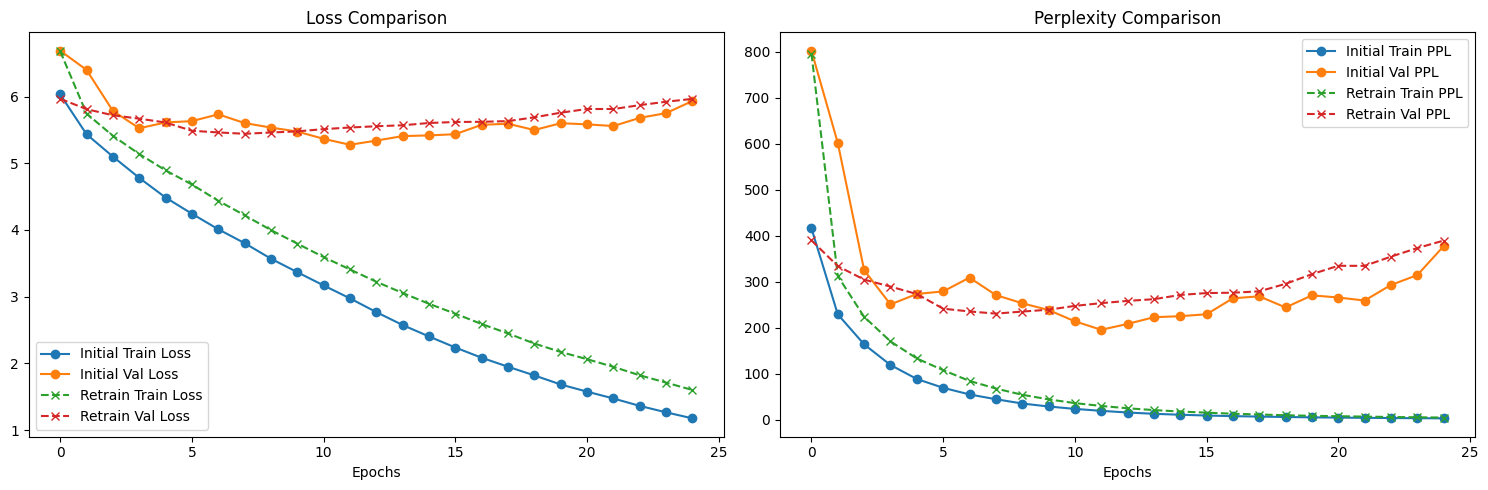

2025-05-03 15:04:18.777 | INFO     | __main__:main:103 - Final Test PPL: 333.70


In [19]:
#new
# Initialize metric trackers
initial_train_losses = []
initial_valid_losses = []
retrain_train_losses = []
retrain_valid_losses = []
def main():

    # Initial setup
    trial_name = 'influence_baseline'
    device = torch.device('cuda' if torch.cuda.is_available() else 'mps'
                        if torch.backends.mps.is_available() else 'cpu')

    # Load data and build vocabulary
    train_data, valid_data, test_data = load_and_preprocess_data()
    word_to_idx, idx_to_word = build_voab(train_data)

    # Process data and create batches
    train_tensors = process_data(train_data, word_to_idx)
    valid_tensors = process_data(valid_data, word_to_idx)
    test_tensors = process_data(test_data, word_to_idx)

    batch_size = 32
    train_batches = create_batches(train_tensors, word_to_idx, batch_size)
    valid_batches = create_batches(valid_tensors, word_to_idx, batch_size)
    test_batches = create_batches(test_tensors, word_to_idx, batch_size)

    # Initialize model
    model = Network(
        vocab_size=len(word_to_idx),
        embed_size=300,
        hidden_size=512,
        num_layers=1
    ).to(device)
      # Verify parameter initialization
    print("Model parameters device:", next(model.parameters()).device)
    criterion = nn.CrossEntropyLoss(ignore_index=word_to_idx['<pad>'])
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Phase 1: Initial Training
    logger.info("Initial Training Phase")
    train_losses, valid_losses = [], []
    for epoch in range(25):
        train_loss = train(model, train_batches, criterion, optimizer, device)
        valid_loss = evaluate(model, valid_batches, criterion, device)

        logger.info(f"Epoch {epoch+1}/25")
        logger.info(f"Train Loss: {train_loss:.2f} | Valid Loss: {valid_loss:.2f}")
        logger.info(f"Train PPL: {calculate_perplexity(train_loss):.2f} | Valid PPL: {calculate_perplexity(valid_loss):.2f}")
        initial_train_losses.append(train_loss)
        initial_valid_losses.append(valid_loss)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

    # Phase 2: Compute Influences
    logger.info("Computing Influence Values")

    # Ensure gradient computation context
    with torch.autograd.set_detect_anomaly(True):
        valid_grad = get_validation_gradients(model, valid_batches, criterion, device)
        influences = compute_influences(model, train_batches, valid_grad, criterion, device)

    # Phase 3: Select Top 30%
    logger.info("Selecting Top 30% Examples")
    selected_data = select_top_examples(train_data, influences, 0.3)
    selected_tensors = process_data(selected_data, word_to_idx)
    selected_batches = create_batches(selected_tensors, word_to_idx, batch_size)

    # Phase 4: Retrain on Selected Data
    logger.info("Retraining on Selected Examples")
    model = Network(  # Reinitialize model
        vocab_size=len(word_to_idx),
        embed_size=300,
        hidden_size=512,
        num_layers=1
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
       # Verify first batch data
    sample_batch = next(iter(train_batches))
    print("Sample batch shape:", sample_batch.shape)
    print("Sample inputs:", sample_batch[0, :-1])
    print("Sample targets:", sample_batch[0, 1:])
    retrain_losses = []
    for epoch in range(25):
        train_loss = train(model, selected_batches, criterion, optimizer, device)
        valid_loss = evaluate(model, valid_batches, criterion, device)

        logger.info(f"Retrain Epoch {epoch+1}/25")
        logger.info(f"Train Loss: {train_loss:.2f} | Valid Loss: {valid_loss:.2f}")
        logger.info(f"Train PPL: {calculate_perplexity(train_loss):.2f} | Valid PPL: {calculate_perplexity(valid_loss):.2f}")
        retrain_train_losses.append(train_loss)
        retrain_valid_losses.append(valid_loss)
        retrain_losses.append(train_loss)

    # Final Evaluation
    visualize_results(
    initial_train_losses,
    initial_valid_losses,
    retrain_train_losses,
    retrain_valid_losses
)
    test_loss = evaluate(model, test_batches, criterion, device)
    logger.info(f"Final Test PPL: {calculate_perplexity(test_loss):.2f}")

if __name__ == "__main__":
    main()

In [21]:
def compare_generations(model1, model2, word_to_idx, idx_to_word, device, 
                       seed_texts=["the", "company", "market"], max_length=20):
    """Compare text generation between two models"""
    print("\n" + "="*50)
    print("Text Generation Comparison")
    print("="*50)
    
    for seed in seed_texts:
        # Generate from both models
        gen1 = generate_text(model1, word_to_idx, idx_to_word, device, seed, max_length)
        gen2 = generate_text(model2, word_to_idx, idx_to_word, device, seed, max_length)
        
        # Display results
        print(f"\nSeed: '{seed}'")
        print(f"Initial Model:  {gen1}")
        print(f"Retrained Model: {gen2}")
        print("-"*60)